# OWID Exploratory Data Analysis

CO2 and Greenhouse Gas Emissions Data by Our World in Data: https://github.com/owid/co2-data

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import altair as alt
import math

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

In [58]:
df = pd.read_csv('dataset/owid/owid-co2-data.csv')
codebook = pd.read_csv('dataset/owid/owid-co2-codebook.csv')

In [59]:
df

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,NaN,NaN,NaN,NaN,0.002,NaN,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,NaN,475.00,0.070,NaN,0.011,NaN,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,NaN,8.70,0.007,NaN,0.012,NaN,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,NaN,0.00,0.000,NaN,0.012,NaN,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,NaN,16.00,0.015,NaN,0.013,NaN,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25199,ZWE,Zimbabwe,2016,10.738,12.153,-12.17,-1.488,1.415,0.765,0.866,...,4.703,11.92,0.85,6.55,0.467,14030338.0,2.096179e+10,47.5,3385.574,1.889
25200,ZWE,Zimbabwe,2017,9.582,11.248,-10.77,-1.156,1.666,0.673,0.790,...,NaN,NaN,NaN,NaN,NaN,14236599.0,2.194784e+10,NaN,NaN,NaN
25201,ZWE,Zimbabwe,2018,11.854,13.163,23.72,2.273,1.308,0.821,0.912,...,NaN,NaN,NaN,NaN,NaN,14438812.0,2.271535e+10,NaN,NaN,NaN
25202,ZWE,Zimbabwe,2019,10.949,12.422,-7.64,-0.905,1.473,0.748,0.848,...,NaN,NaN,NaN,NaN,NaN,14645473.0,NaN,NaN,NaN,NaN


The codebook provides description and the source for each variable in the dataset.

In [60]:
codebook.head()

,column,description,source
0,iso_code,ISO 3166-1 alpha-3 – three-letter country codes,International Organization for Standardization
1,country,Geographic location,Our World in Data
2,year,Year of observation,Our World in Data
3,co2,Annual production-based emissions of carbon di...,Global Carbon Project
4,co2_per_capita,Annual production-based emissions of carbon di...,Our World in Data based on the Global Carbon P...


## Dataset Overview

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25204 entries, 0 to 25203
Data columns (total 58 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   iso_code                             21948 non-null  object 
 1   country                              25204 non-null  object 
 2   year                                 25204 non-null  int64  
 3   co2                                  23949 non-null  float64
 4   consumption_co2                      3976 non-null   float64
 5   co2_growth_prct                      24931 non-null  float64
 6   co2_growth_abs                       23585 non-null  float64
 7   trade_co2                            3976 non-null   float64
 8   co2_per_capita                       23307 non-null  float64
 9   consumption_co2_per_capita           3976 non-null   float64
 10  share_global_co2                     23949 non-null  float64
 11  cumulative_co2              

In [62]:
df.describe()

,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
count,25204.000000,23949.000000,3976.000000,24931.000000,23585.000000,3976.000000,23307.000000,3976.000000,23949.000000,2.394900e+04,...,5155.000000,5211.000000,5157.000000,5211.000000,5157.000000,2.287800e+04,1.353800e+04,8690.000000,8681.000000,6803.000000
mean,1953.225797,267.861942,916.755170,21.098600,5.146889,-2.415624,4.170811,6.567721,4.983979,1.035710e+04,...,8.099506,82.253370,2.046923,29.308135,0.606690,7.072322e+07,2.877088e+11,1569.083895,25568.487454,1.850291
std,53.791369,1521.680894,3373.348275,702.565991,55.259760,182.444942,14.912201,6.927957,17.704994,6.120603e+04,...,9.387477,566.702756,3.534126,199.291118,0.844671,3.795858e+08,2.180094e+12,9066.102799,33319.956208,1.575161
min,1750.000000,0.000000,0.197000,-99.640000,-1895.244000,-1657.998000,0.000000,0.055000,0.000000,0.000000e+00,...,-50.487000,0.000000,0.000000,0.000000,0.000000,1.490000e+03,5.543200e+07,0.000000,0.000000,0.050000
25%,1925.000000,0.528000,10.319750,-0.450000,-0.011000,-0.892500,0.253000,1.240250,0.010000,6.992000e+00,...,2.514000,2.150000,0.715000,0.535000,0.228000,1.291899e+06,9.828867e+09,6.997000,3270.369000,0.856000
50%,1967.000000,4.857000,57.091000,3.350000,0.059000,1.953000,1.250000,4.359500,0.060000,9.131800e+01,...,5.474000,9.030000,1.111000,3.590000,0.384000,4.880320e+06,3.037019e+10,61.404500,13701.318000,1.407000
75%,1995.000000,42.818000,276.378750,10.460000,1.103000,9.700500,4.657500,9.848500,0.600000,1.147514e+03,...,10.299000,31.055000,1.690000,10.570000,0.607000,1.759622e+07,1.268944e+11,352.884500,35493.775000,2.351000
max,2020.000000,36702.503000,36702.503000,102318.510000,1736.258000,1028.487000,748.639000,57.792000,100.000000,1.696524e+06,...,86.991000,8660.010000,39.812000,3054.000000,8.239000,7.794799e+09,1.136302e+14,162194.290000,317582.498000,13.493000


In [63]:
# change 'year' to string object
df = df.astype({'year': str})
print(df['year'].dtypes)

object


## Missing value identification

In [64]:
# function to count missing value
def get_nan(df, sort=False):
    missing_value = df[df.isna().values.any(axis=1)]
    rows = missing_value.shape[0]
    print(rows, "rows with missing values")
    
    if rows < 0:
        return 0
    if sort:
        print(df.isna().sum().sort_values())
    else:
        print(df.isna().sum())
        

In [65]:
get_nan(df, sort=True)

24156 rows with missing values
country                                    0
year                                       0
co2_growth_prct                          273
cumulative_co2                          1255
co2                                     1255
share_global_cumulative_co2             1255
share_global_co2                        1255
co2_growth_abs                          1619
co2_per_capita                          1897
population                              2326
iso_code                                3256
share_global_oil_co2                    4665
share_global_cumulative_oil_co2         4665
cumulative_oil_co2                      4665
oil_co2                                 4665
oil_co2_per_capita                      5023
share_global_coal_co2                   8016
coal_co2                                8016
cumulative_coal_co2                     8016
share_global_cumulative_coal_co2        8016
coal_co2_per_capita                     8344
co2_per_gdp             

In [66]:
# function to visualize the proportion of missing value
def visual_nan(df, name="", isSorted=False, savePlot=True):
    
    sort = ''
    if isSorted:
        df=df[df.isna().sum().sort_values().keys()]
        sort = '_sorted'
    missing_value = df.isna().melt(value_name="missing")

    ax = sns.displot(data=missing_value,
                      y="variable",
                      hue="missing",
                      multiple="fill",
                      height=10,
                      aspect=1.5)
    plt.xlabel("Proportion of missing value")
    plt.title(f"Missing values of {name}")
    
    if savePlot:
        filename = name.split('.')
        plt.savefig(f"plot/{filename[0]}{sort}.png")

    return ax

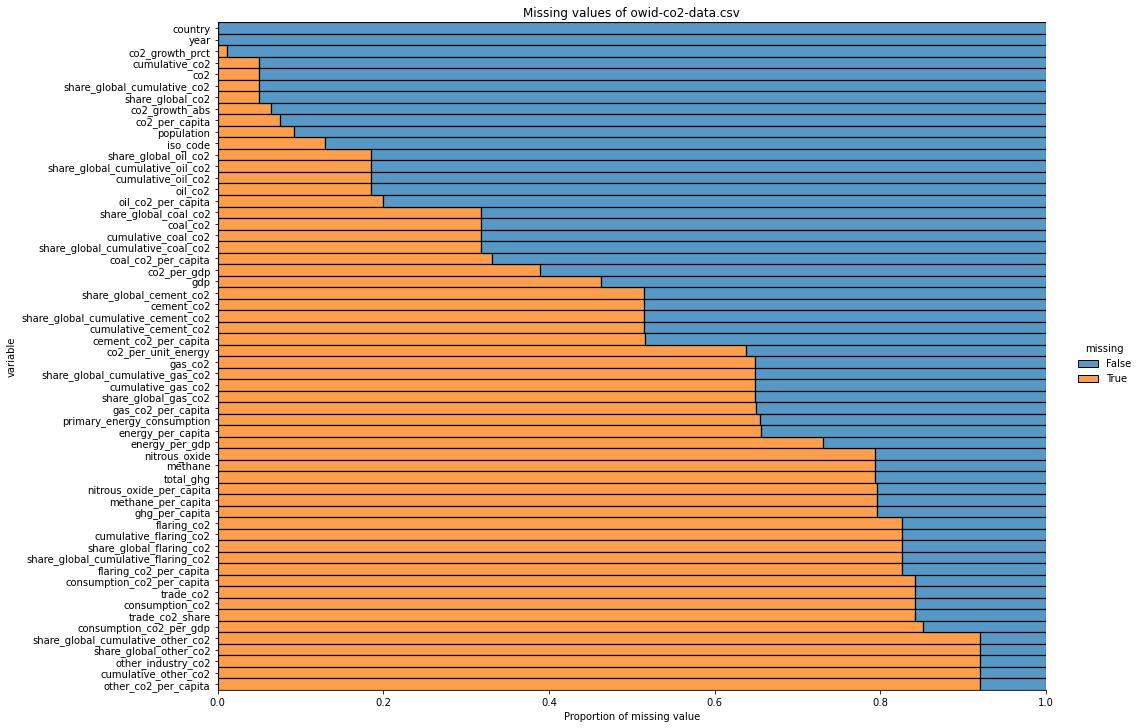

In [67]:
visual_nan(df, 'owid-co2-data.csv', isSorted=True)

In [68]:
missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
missing.reset_index(inplace=True)
missing.rename(columns={'index':'col'}, inplace=True)
missing['ratio'] = (missing['missing']/len(df)*100).round(2)
missing_list = missing[missing['ratio'] > 70]['col'].tolist()
missing_list

['consumption_co2',
 'trade_co2',
 'consumption_co2_per_capita',
 'consumption_co2_per_gdp',
 'flaring_co2',
 'other_industry_co2',
 'flaring_co2_per_capita',
 'other_co2_per_capita',
 'trade_co2_share',
 'share_global_flaring_co2',
 'share_global_other_co2',
 'cumulative_flaring_co2',
 'cumulative_other_co2',
 'share_global_cumulative_flaring_co2',
 'share_global_cumulative_other_co2',
 'total_ghg',
 'ghg_per_capita',
 'methane',
 'methane_per_capita',
 'nitrous_oxide',
 'nitrous_oxide_per_capita',
 'energy_per_gdp']

In [69]:
# function to display the number of missing values and missing ratio
def missing_ratio_summary(df):
    missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
    missing.reset_index(inplace=True)
    missing.rename(columns={'index':'col'}, inplace=True)
    missing['ratio'] = (missing['missing']/len(df)*100).round(2)

    display(missing.sort_values(by=['ratio']))
    
# function to return a list of columns with more than x% of missing values 
def get_X_missing(df, X):
    missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
    missing.reset_index(inplace=True)
    missing.rename(columns={'index':'col'}, inplace=True)
    missing['ratio'] = (missing['missing']/len(df)*100).round(2)
    
    missing_list = missing[missing['ratio'] > X]['col'].tolist()
    return missing_list
    
missing_ratio_summary(df)

,col,missing,ratio
1,country,0,0.00
2,year,0,0.00
5,co2_growth_prct,273,1.08
11,cumulative_co2,1255,4.98
3,co2,1255,4.98
12,share_global_cumulative_co2,1255,4.98
10,share_global_co2,1255,4.98
6,co2_growth_abs,1619,6.42
8,co2_per_capita,1897,7.53
53,population,2326,9.23


... something need to be done ...

## Outlier detection

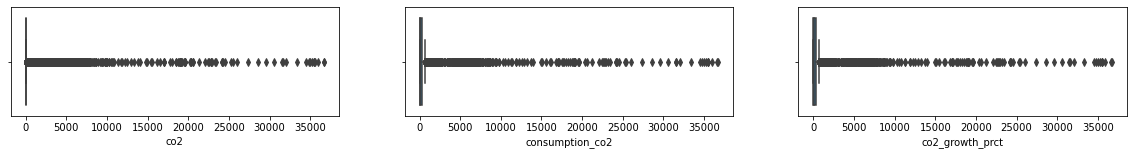

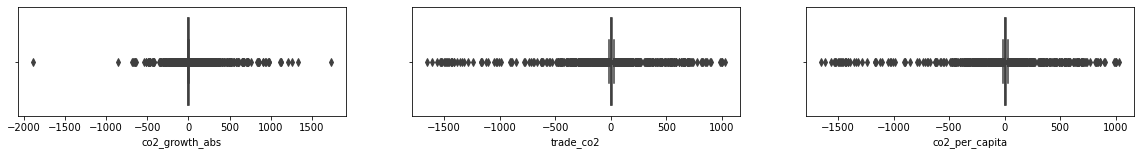

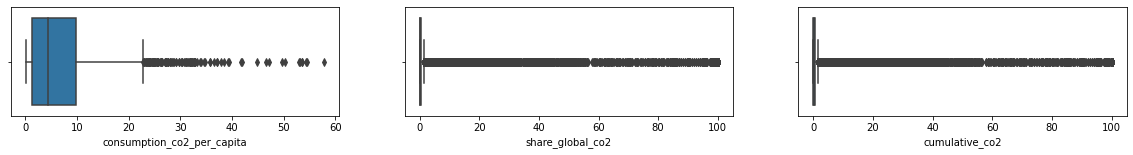

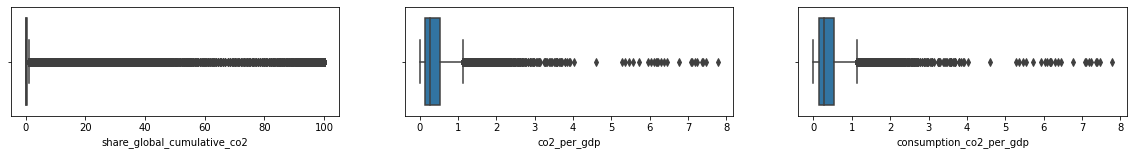

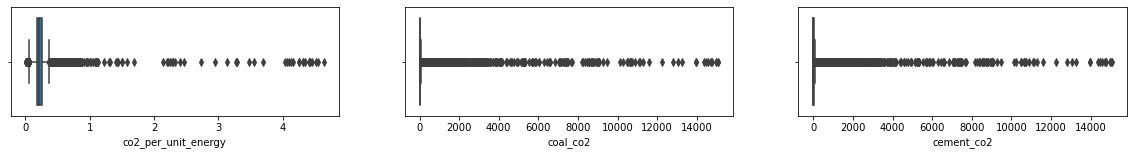

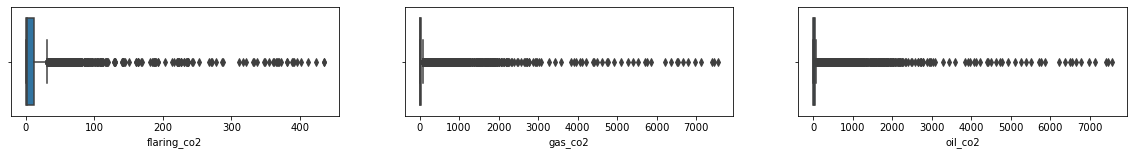

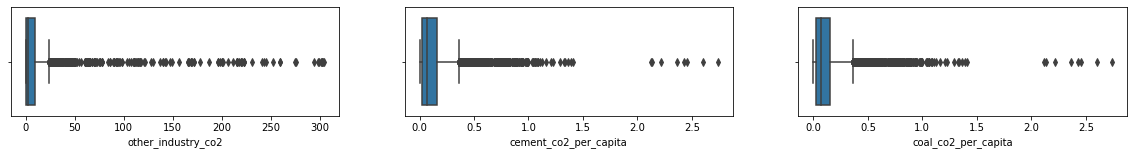

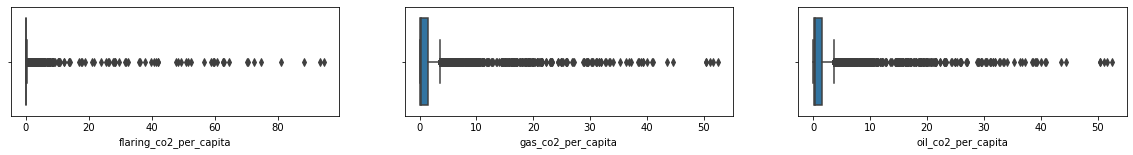

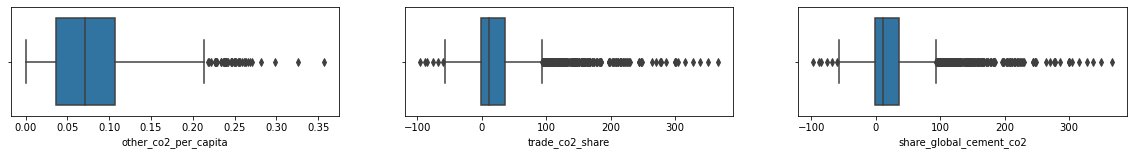

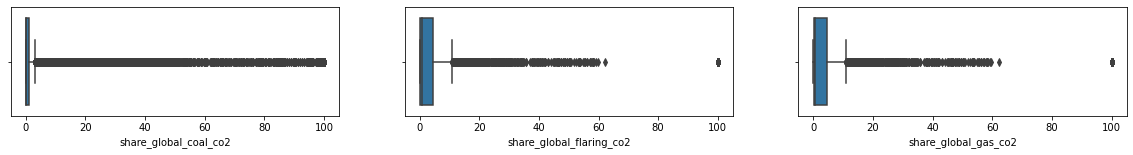

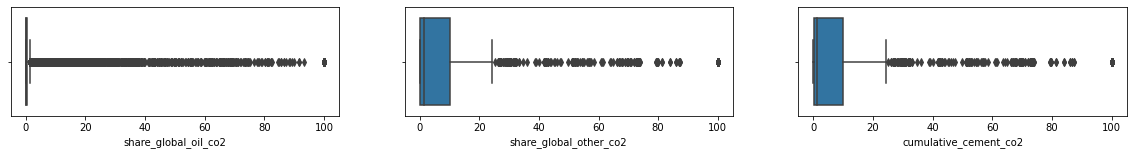

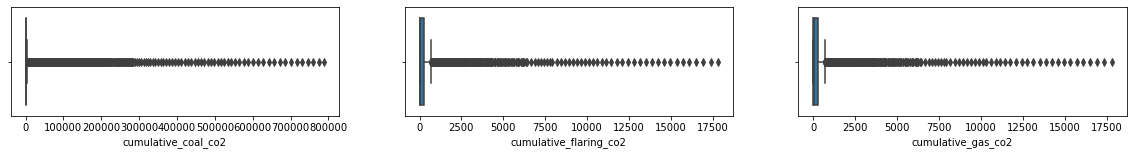

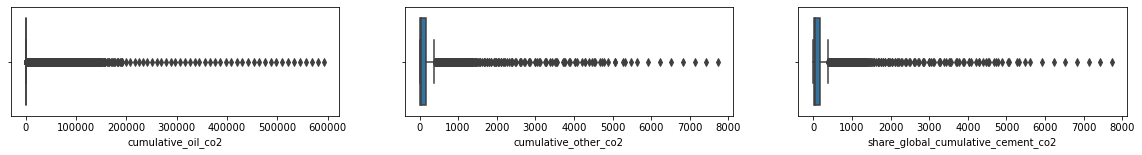

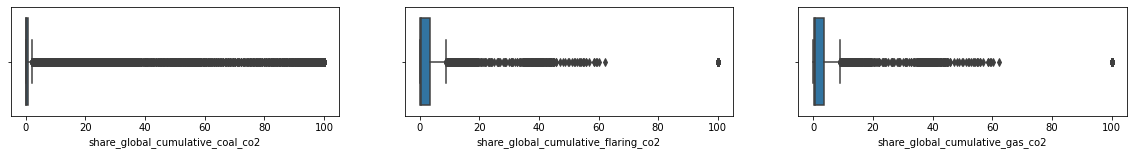

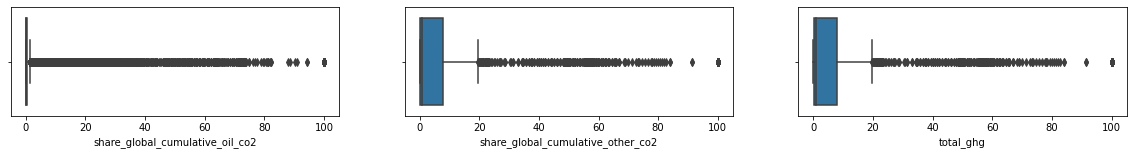

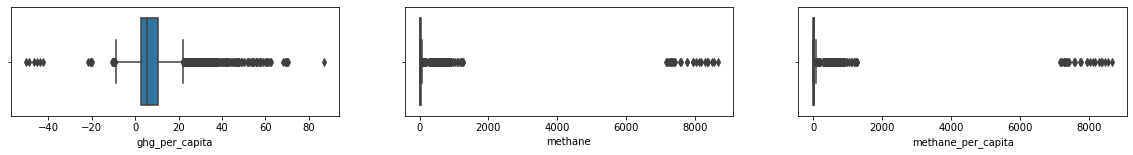

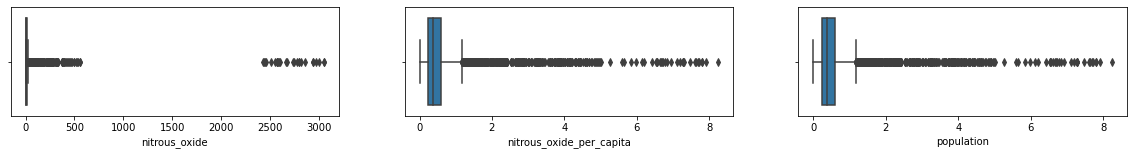

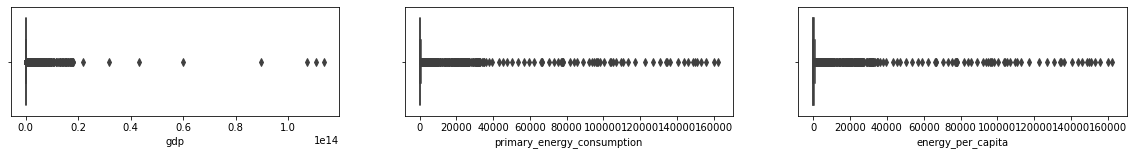

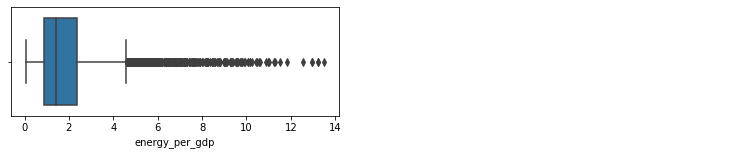

In [70]:
# function to plot boxplot
def plot_boxplot(series, title='', xlabel=''):
    bp = sns.boxplot(x=series)
    bp.set(title=title,
           xlabel=xlabel)
    return bp

# function to plot boxplot for all numeric columns
def check_outlier(df):
    numeric_columns = df.describe().columns.copy()
    num_of_columns = len(numeric_columns)
    
    for i in range(math.ceil(num_of_columns/3)):
        c = 3*i
        
        plt.figure(figsize=(20,2))
        
        plt.subplot(1, 3, 1)
        plot_boxplot(df[numeric_columns[c]], xlabel=numeric_columns[c])
        
        plt.subplot(1, 3, 2)
        try:
            plot_boxplot(df[numeric_columns[c+1]], xlabel=numeric_columns[c+1])
        except IndexError:
            plt.xticks([]), plt.yticks([])
            plt.axis("off")
            break
        
        plt.subplot(1, 3, 3)
        try:
            plot_boxplot(df[numeric_columns[c+1]], xlabel=numeric_columns[c+2])
        except IndexError:
            plt.xticks([]), plt.yticks([])
            plt.axis("off")
            break
        plt.show()

        
check_outlier(df)

In [71]:
# function to plot an interactive boxplot 
def check_outlier_px(df, col_name):    
    try:
        fig = px.box(df, y=col_name)
        fig.show()
    except Exception as ex:
        print('Something went wrong')

In [72]:
check_outlier_px(df, 'year')

## Categorical data

In [73]:
unique_iso_codes = df.iso_code.unique()
unique_countries = df.country.unique()
unique_years = df.year.unique()

In [74]:
print(unique_iso_codes)
print(len(unique_iso_codes))

['AFG' nan 'ALB' 'DZA' 'AND' 'AGO' 'AIA' 'ATA' 'ATG' 'ARG' 'ARM' 'ABW'
 'AUS' 'AUT' 'AZE' 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL' 'BLZ' 'BEN' 'BMU'
 'BTN' 'BOL' 'BES' 'BIH' 'BWA' 'BRA' 'VGB' 'BRN' 'BGR' 'BFA' 'BDI' 'KHM'
 'CMR' 'CAN' 'CPV' 'CAF' 'TCD' 'CHL' 'CHN' 'CXR' 'COL' 'COM' 'COG' 'COK'
 'CRI' 'CIV' 'HRV' 'CUB' 'CUW' 'CYP' 'CZE' 'COD' 'DNK' 'DJI' 'DMA' 'DOM'
 'ECU' 'EGY' 'SLV' 'GNQ' 'ERI' 'EST' 'SWZ' 'ETH' 'FRO' 'FJI' 'FIN' 'FRA'
 'GUF' 'PYF' 'GAB' 'GMB' 'GEO' 'DEU' 'GHA' 'GRC' 'GRL' 'GRD' 'GLP' 'GTM'
 'GIN' 'GNB' 'GUY' 'HTI' 'HND' 'HKG' 'HUN' 'ISL' 'IND' 'IDN' 'IRN' 'IRQ'
 'IRL' 'ISR' 'ITA' 'JAM' 'JPN' 'JOR' 'KAZ' 'KEN' 'KIR' 'OWID_KOS' 'KWT'
 'KGZ' 'LAO' 'LVA' 'LBN' 'LSO' 'LBR' 'LBY' 'LIE' 'LTU' 'LUX' 'MDG' 'MWI'
 'MYS' 'MDV' 'MLI' 'MLT' 'MHL' 'MTQ' 'MRT' 'MUS' 'MYT' 'MEX' 'MDA' 'MNG'
 'MNE' 'MSR' 'MAR' 'MOZ' 'MMR' 'NAM' 'NRU' 'NPL' 'NLD' 'NCL' 'NZL' 'NIC'
 'NER' 'NGA' 'NIU' 'PRK' 'MKD' 'NOR' 'OMN' 'PAK' 'PLW' 'PSE' 'PAN' 'PNG'
 'PRY' 'PER' 'PHL' 'POL' 'PRT' 'PRI' 'QAT' 'ROU' 'RUS'

In [75]:
print(unique_countries)
print(len(unique_countries))

['Afghanistan' 'Africa' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antarctica' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Asia'
 'Asia (excl. China & India)' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bermuda' 'Bhutan' 'Bolivia' 'Bonaire Sint Eustatius and Saba'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'British Virgin Islands'
 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon'
 'Canada' 'Cape Verde' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Christmas Island' 'Colombia' 'Comoros' 'Congo' 'Cook Islands'
 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Curacao' 'Cyprus'
 'Czechia' 'Democratic Republic of Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'EU-27' 'EU-28' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Europe'
 'Europe (excl. EU-27)' 'Europe (excl. EU-28)' 'Faeroe Islands' 'Fiji'
 'Finland' 'F

In [76]:
unique_years.sort()
print(unique_years)
print(len(unique_years))

['1750' '1751' '1752' '1753' '1754' '1755' '1756' '1757' '1758' '1759'
 '1760' '1761' '1762' '1763' '1764' '1765' '1766' '1767' '1768' '1769'
 '1770' '1771' '1772' '1773' '1774' '1775' '1776' '1777' '1778' '1779'
 '1780' '1781' '1782' '1783' '1784' '1785' '1786' '1787' '1788' '1789'
 '1790' '1791' '1792' '1793' '1794' '1795' '1796' '1797' '1798' '1799'
 '1800' '1801' '1802' '1803' '1804' '1805' '1806' '1807' '1808' '1809'
 '1810' '1811' '1812' '1813' '1814' '1815' '1816' '1817' '1818' '1819'
 '1820' '1821' '1822' '1823' '1824' '1825' '1826' '1827' '1828' '1829'
 '1830' '1831' '1832' '1833' '1834' '1835' '1836' '1837' '1838' '1839'
 '1840' '1841' '1842' '1843' '1844' '1845' '1846' '1847' '1848' '1849'
 '1850' '1851' '1852' '1853' '1854' '1855' '1856' '1857' '1858' '1859'
 '1860' '1861' '1862' '1863' '1864' '1865' '1866' '1867' '1868' '1869'
 '1870' '1871' '1872' '1873' '1874' '1875' '1876' '1877' '1878' '1879'
 '1880' '1881' '1882' '1883' '1884' '1885' '1886' '1887' '1888' '1889'
 '1890

In [77]:
# plt.figure(figsize=(30, 3))
# sns.countplot(x="iso_code", data=df, palette='rocket')

In [78]:
px.histogram(df, x="iso_code")

In [79]:
px.histogram(df, x="country")

In [80]:
px.histogram(df.sort_values(by=['year']), x="year")

## Top countries that produce the most Carbon Dioxide (CO2)

China, US, India

In [81]:
# function to slice out country from the master df
def get_country_data(df, country_name):
    df_country = df[df['country'] == f'{country_name}']
    df_country.reset_index(inplace=True, drop=True)
    return df_country

#### China

In [82]:
df_china_raw = get_country_data(df, 'China')
print(df_china_raw.shape)

(122, 58)


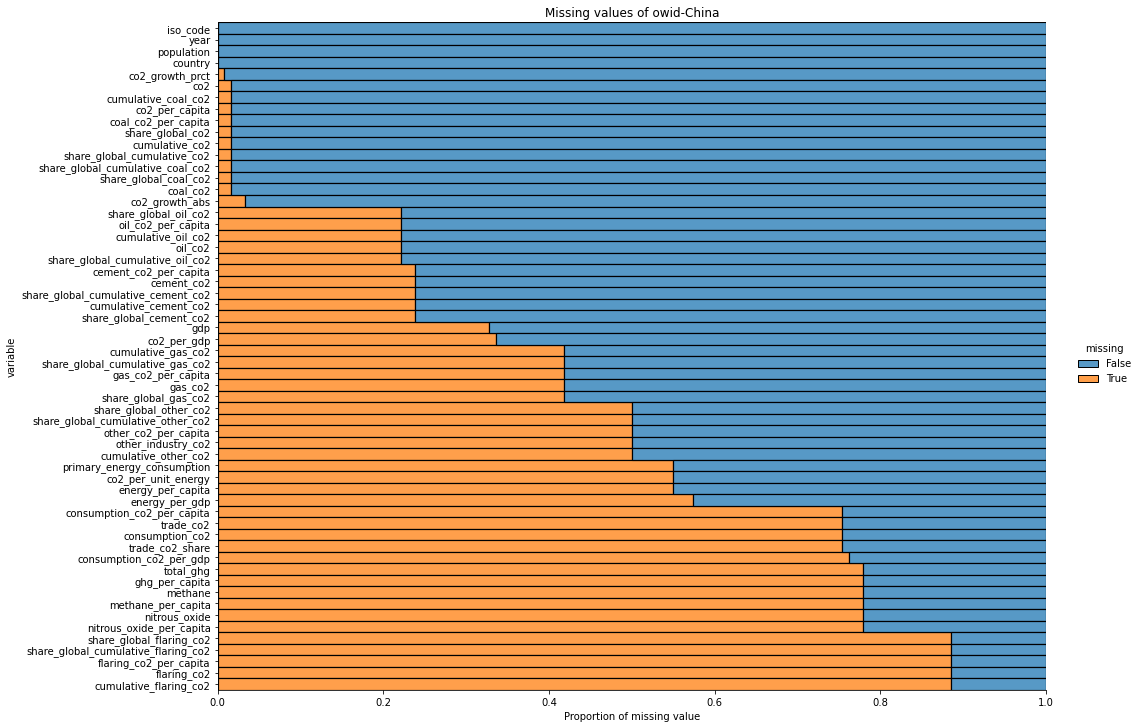

In [83]:
visual_nan(df_china_raw, name='owid-China', isSorted=True)

In [84]:
missing_ratio_summary(df_china_raw)

,col,missing,ratio
0,iso_code,0,0.00
2,year,0,0.00
53,population,0,0.00
1,country,0,0.00
5,co2_growth_prct,1,0.82
3,co2,2,1.64
36,cumulative_coal_co2,2,1.64
8,co2_per_capita,2,1.64
23,coal_co2_per_capita,2,1.64
10,share_global_co2,2,1.64


### Handling Missing Values

| Percentage of Missing values | Action                                           |
| :--------------------------- | :----------------------------------------------- |
| [ 0%,  70%]                  | Multivariate imputation                          |
| (70%, 100%]                  | Drop column                                      |
  
Columns with *more than* 70% of missing values are dropped. 

Use `get_X_missing(df, X)` function to get a list of columns that applies.

In [85]:
col_to_drop_china = get_X_missing(df_china_raw, 70) # columns that have more than 70% missing values
print(len(col_to_drop_china))
print(col_to_drop_china)

16
['consumption_co2', 'trade_co2', 'consumption_co2_per_capita', 'consumption_co2_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'trade_co2_share', 'share_global_flaring_co2', 'cumulative_flaring_co2', 'share_global_cumulative_flaring_co2', 'total_ghg', 'ghg_per_capita', 'methane', 'methane_per_capita', 'nitrous_oxide', 'nitrous_oxide_per_capita']


In [86]:
df_china = df_china_raw.drop(col_to_drop_china, axis=1)
df_china

,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,...,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,CHN,China,1899,0.095,NaN,NaN,0.000,0.01,0.095,0.00,...,NaN,0.00,NaN,NaN,NaN,3.994218e+08,NaN,NaN,NaN,NaN
1,CHN,China,1900,NaN,0.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.015797e+08,3.888000e+11,NaN,NaN,NaN
2,CHN,China,1901,NaN,0.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.037865e+08,NaN,NaN,NaN,NaN
3,CHN,China,1902,0.095,0.00,NaN,0.000,0.00,0.191,0.00,...,NaN,0.00,NaN,NaN,NaN,4.060427e+08,NaN,NaN,NaN,NaN
4,CHN,China,1903,1.964,1961.54,1.869,0.005,0.09,2.154,0.00,...,NaN,0.00,NaN,NaN,NaN,4.083487e+08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,CHN,China,2016,9720.444,-1.30,-127.976,6.874,27.42,194195.688,12.51,...,31.40,20.25,1.84,4.89,49.55,1.414049e+09,1.725547e+13,35264.122,24938.401,2.087
118,CHN,China,2017,9920.459,2.06,200.015,6.981,27.61,204116.147,12.85,...,32.15,20.81,1.99,5.03,49.79,1.421022e+09,1.757508e+13,36342.177,25574.677,NaN
119,CHN,China,2018,10289.990,3.72,369.530,7.208,28.08,214406.137,13.19,...,32.86,21.37,2.15,5.19,50.04,1.427648e+09,1.815162e+13,37714.113,26416.955,NaN
120,CHN,China,2019,10489.989,1.94,199.999,7.316,28.58,224896.125,13.53,...,33.58,21.92,2.32,5.34,50.32,1.433784e+09,NaN,39360.925,27452.478,NaN


Doing the same to **United States** and **India**.

#### United States

(221, 58)


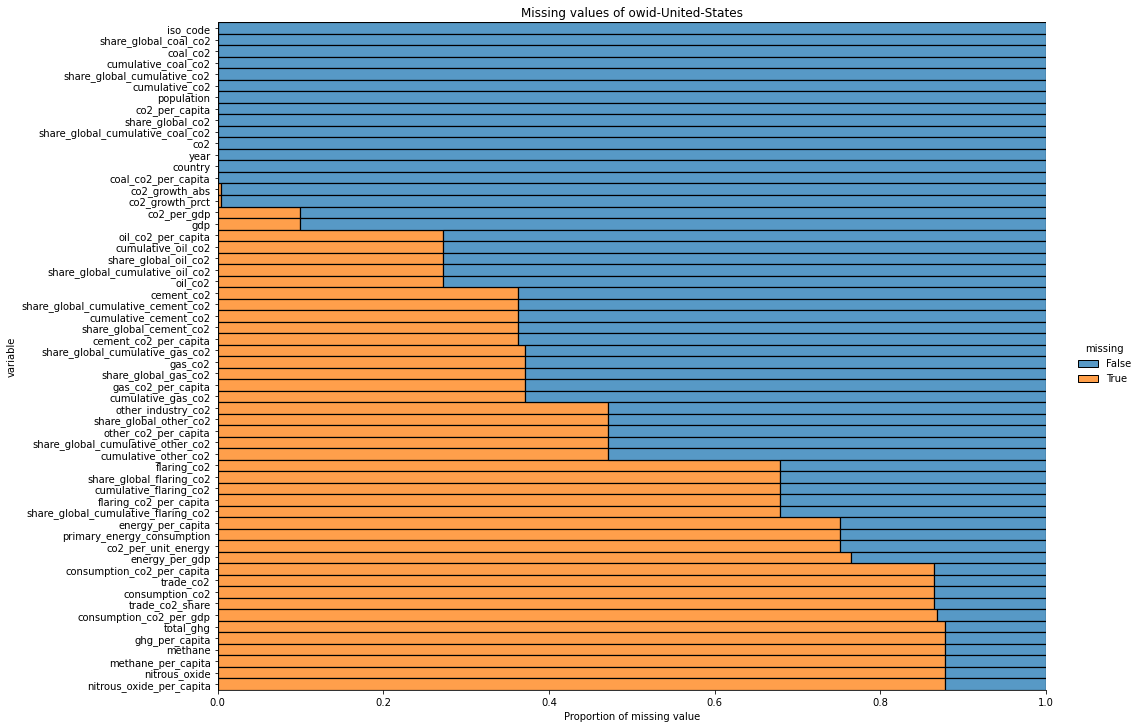

In [87]:
df_us_raw = get_country_data(df, 'United States')
print(df_us_raw.shape)
visual_nan(df_us_raw, name='owid-United-States', isSorted=True)

In [88]:
col_to_drop_us = get_X_missing(df_us_raw, 70) # columns that have more than 70% missing values
print(len(col_to_drop_us))
print(f"A list of columns to drop: \n{col_to_drop_us}")

df_us = df_us_raw.drop(col_to_drop_us, axis=1)
df_us

15
A list of columns to drop: 
['consumption_co2', 'trade_co2', 'consumption_co2_per_capita', 'consumption_co2_per_gdp', 'co2_per_unit_energy', 'trade_co2_share', 'total_ghg', 'ghg_per_capita', 'methane', 'methane_per_capita', 'nitrous_oxide', 'nitrous_oxide_per_capita', 'primary_energy_consumption', 'energy_per_capita', 'energy_per_gdp']


,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,...,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,population,gdp
0,USA,United States,1800,0.253,NaN,NaN,0.042,0.90,0.253,0.03,...,NaN,NaN,NaN,0.03,NaN,NaN,NaN,NaN,6000000.0,NaN
1,USA,United States,1801,0.267,5.80,0.015,0.044,0.96,0.520,0.06,...,NaN,NaN,NaN,0.06,NaN,NaN,NaN,NaN,6113782.0,NaN
2,USA,United States,1802,0.289,8.22,0.022,0.046,0.79,0.810,0.10,...,NaN,NaN,NaN,0.10,NaN,NaN,NaN,NaN,6229723.0,NaN
3,USA,United States,1803,0.297,2.53,0.007,0.047,0.94,1.107,0.13,...,NaN,NaN,NaN,0.13,NaN,NaN,NaN,NaN,6347862.0,NaN
4,USA,United States,1804,0.333,12.35,0.037,0.052,0.97,1.440,0.16,...,NaN,NaN,NaN,0.16,NaN,NaN,NaN,NaN,6468241.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,USA,United States,2016,5248.024,-2.30,-123.747,16.247,14.80,396171.260,25.52,...,149222.148,1282.985,7.01,23.41,12.17,32.49,27.38,15.74,323015992.0,1.716256e+13
217,USA,United States,2017,5207.751,-0.77,-40.273,16.020,14.50,401379.012,25.27,...,151487.474,1310.175,6.84,23.14,12.20,32.12,27.19,15.50,325084758.0,1.759628e+13
218,USA,United States,2018,5375.491,3.22,167.739,16.434,14.67,406754.502,25.03,...,153804.284,1334.303,6.67,22.86,12.32,31.79,27.02,15.25,327096263.0,1.814065e+13
219,USA,United States,2019,5255.816,-2.23,-119.674,15.972,14.32,412010.318,24.79,...,156117.656,1357.594,6.51,22.57,12.50,31.49,26.85,14.99,329064917.0,NaN


#### India

(163, 58)


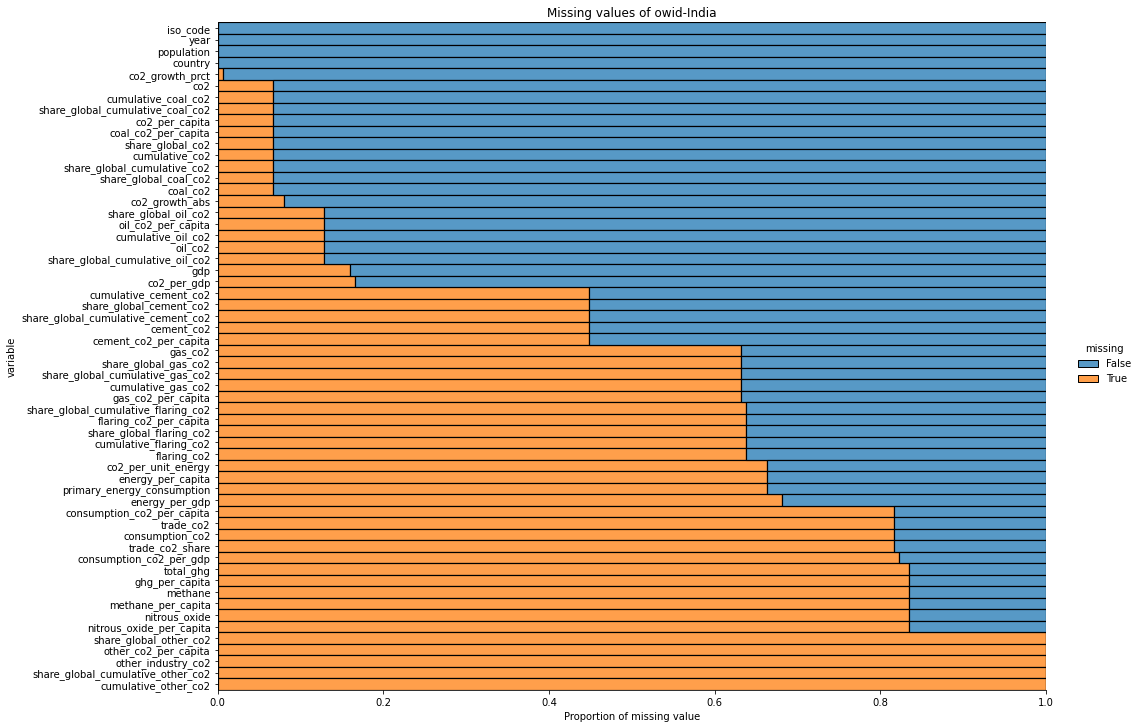

In [89]:
df_india_raw = get_country_data(df, 'India')
print(df_india_raw.shape)
visual_nan(df_india_raw, name='owid-India', isSorted=True)

In [90]:
col_to_drop_india = get_X_missing(df_india_raw, 70) # columns that have more than 70% missing values
print(len(col_to_drop_india))
print(f"A list of columns to drop: \n{col_to_drop_india}")

df_india = df_india_raw.drop(col_to_drop_india, axis=1)
df_india

16
A list of columns to drop: 
['consumption_co2', 'trade_co2', 'consumption_co2_per_capita', 'consumption_co2_per_gdp', 'other_industry_co2', 'other_co2_per_capita', 'trade_co2_share', 'share_global_other_co2', 'cumulative_other_co2', 'share_global_cumulative_other_co2', 'total_ghg', 'ghg_per_capita', 'methane', 'methane_per_capita', 'nitrous_oxide', 'nitrous_oxide_per_capita']


,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,...,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,IND,India,1858,0.395,NaN,NaN,0.002,0.14,0.395,0.01,...,NaN,0.01,NaN,NaN,NaN,2.434556e+08,NaN,NaN,NaN,NaN
1,IND,India,1859,0.637,61.34,0.242,0.003,0.21,1.032,0.01,...,NaN,0.01,NaN,NaN,NaN,2.444292e+08,NaN,NaN,NaN,NaN
2,IND,India,1860,0.644,1.04,0.007,0.003,0.19,1.676,0.02,...,NaN,0.02,NaN,NaN,NaN,2.454067e+08,NaN,NaN,NaN,NaN
3,IND,India,1861,0.498,-22.68,-0.146,0.002,0.14,2.174,0.03,...,NaN,0.03,NaN,NaN,NaN,2.463880e+08,2.196186e+11,NaN,NaN,NaN
4,IND,India,1862,0.551,10.67,0.053,0.002,0.16,2.726,0.03,...,NaN,0.03,NaN,NaN,NaN,2.473732e+08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,IND,India,2016,2382.223,5.01,113.656,1.799,6.72,44315.067,2.85,...,5.29,3.93,0.99,0.86,2.13,1.324517e+09,7.767450e+12,8352.070,6305.748,1.105
159,IND,India,2017,2433.856,2.17,51.633,1.818,6.77,46748.923,2.94,...,5.40,4.07,0.98,0.88,2.20,1.338677e+09,8.275647e+12,8704.049,6501.978,NaN
160,IND,India,2018,2599.806,6.82,165.950,1.922,7.09,49348.729,3.04,...,5.53,4.21,0.96,0.91,2.27,1.352642e+09,8.835758e+12,9250.506,6838.842,NaN
161,IND,India,2019,2625.968,1.01,26.162,1.922,7.15,51974.697,3.13,...,5.66,4.35,0.95,0.93,2.33,1.366418e+09,NaN,9460.984,6923.931,NaN


### Intersecting Columns

Finding the intersecting columns of `df_china`, `df_us`, and `df_india`.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Intersection_of_3_circles_7.svg/1073px-Intersection_of_3_circles_7.svg.png" width=20%>

In [91]:
print(df_china.shape[1])
col_china = df_china.columns.tolist()
print(col_china)

print(df_us.shape[1])
col_us = df_us.columns.tolist()
print(col_us)

print(df_india.shape[1])
col_india = df_india.columns.tolist()
print(col_india)

42
['iso_code', 'country', 'year', 'co2', 'co2_growth_prct', 'co2_growth_abs', 'co2_per_capita', 'share_global_co2', 'cumulative_co2', 'share_global_cumulative_co2', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2', 'cement_co2', 'gas_co2', 'oil_co2', 'other_industry_co2', 'cement_co2_per_capita', 'coal_co2_per_capita', 'gas_co2_per_capita', 'oil_co2_per_capita', 'other_co2_per_capita', 'share_global_cement_co2', 'share_global_coal_co2', 'share_global_gas_co2', 'share_global_oil_co2', 'share_global_other_co2', 'cumulative_cement_co2', 'cumulative_coal_co2', 'cumulative_gas_co2', 'cumulative_oil_co2', 'cumulative_other_co2', 'share_global_cumulative_cement_co2', 'share_global_cumulative_coal_co2', 'share_global_cumulative_gas_co2', 'share_global_cumulative_oil_co2', 'share_global_cumulative_other_co2', 'population', 'gdp', 'primary_energy_consumption', 'energy_per_capita', 'energy_per_gdp']
43
['iso_code', 'country', 'year', 'co2', 'co2_growth_prct', 'co2_growth_abs', 'co2_per_capita', 

In [92]:
china_us = np.intersect1d(col_china, col_us)
china_us_india = np.intersect1d(china_us, col_india)
print(len(china_us_india))
print(china_us_india)

33
['cement_co2' 'cement_co2_per_capita' 'co2' 'co2_growth_abs'
 'co2_growth_prct' 'co2_per_capita' 'co2_per_gdp' 'coal_co2'
 'coal_co2_per_capita' 'country' 'cumulative_cement_co2' 'cumulative_co2'
 'cumulative_coal_co2' 'cumulative_gas_co2' 'cumulative_oil_co2' 'gas_co2'
 'gas_co2_per_capita' 'gdp' 'iso_code' 'oil_co2' 'oil_co2_per_capita'
 'population' 'share_global_cement_co2' 'share_global_co2'
 'share_global_coal_co2' 'share_global_cumulative_cement_co2'
 'share_global_cumulative_co2' 'share_global_cumulative_coal_co2'
 'share_global_cumulative_gas_co2' 'share_global_cumulative_oil_co2'
 'share_global_gas_co2' 'share_global_oil_co2' 'year']


In [93]:
df_china

,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,...,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,CHN,China,1899,0.095,NaN,NaN,0.000,0.01,0.095,0.00,...,NaN,0.00,NaN,NaN,NaN,3.994218e+08,NaN,NaN,NaN,NaN
1,CHN,China,1900,NaN,0.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.015797e+08,3.888000e+11,NaN,NaN,NaN
2,CHN,China,1901,NaN,0.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.037865e+08,NaN,NaN,NaN,NaN
3,CHN,China,1902,0.095,0.00,NaN,0.000,0.00,0.191,0.00,...,NaN,0.00,NaN,NaN,NaN,4.060427e+08,NaN,NaN,NaN,NaN
4,CHN,China,1903,1.964,1961.54,1.869,0.005,0.09,2.154,0.00,...,NaN,0.00,NaN,NaN,NaN,4.083487e+08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,CHN,China,2016,9720.444,-1.30,-127.976,6.874,27.42,194195.688,12.51,...,31.40,20.25,1.84,4.89,49.55,1.414049e+09,1.725547e+13,35264.122,24938.401,2.087
118,CHN,China,2017,9920.459,2.06,200.015,6.981,27.61,204116.147,12.85,...,32.15,20.81,1.99,5.03,49.79,1.421022e+09,1.757508e+13,36342.177,25574.677,NaN
119,CHN,China,2018,10289.990,3.72,369.530,7.208,28.08,214406.137,13.19,...,32.86,21.37,2.15,5.19,50.04,1.427648e+09,1.815162e+13,37714.113,26416.955,NaN
120,CHN,China,2019,10489.989,1.94,199.999,7.316,28.58,224896.125,13.53,...,33.58,21.92,2.32,5.34,50.32,1.433784e+09,NaN,39360.925,27452.478,NaN


In [94]:
col = df.columns.tolist()
cols_to_drop = list(set(col) - set(china_us_india))

# drop columns one last time
df_china2 = df_china.drop(cols_to_drop, axis=1, errors='ignore') # in case the columns were dropped previously
display(df_china2)
df_us2 = df_us.drop(cols_to_drop, axis=1, errors='ignore')
display(df_us2)
df_india2 = df_india.drop(cols_to_drop, axis=1, errors='ignore')
display(df_india2)

,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,...,cumulative_cement_co2,cumulative_coal_co2,cumulative_gas_co2,cumulative_oil_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,population,gdp
0,CHN,China,1899,0.095,NaN,NaN,0.000,0.01,0.095,0.00,...,NaN,0.095,NaN,NaN,NaN,0.00,NaN,NaN,3.994218e+08,NaN
1,CHN,China,1900,NaN,0.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.015797e+08,3.888000e+11
2,CHN,China,1901,NaN,0.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.037865e+08,NaN
3,CHN,China,1902,0.095,0.00,NaN,0.000,0.00,0.191,0.00,...,NaN,0.191,NaN,NaN,NaN,0.00,NaN,NaN,4.060427e+08,NaN
4,CHN,China,1903,1.964,1961.54,1.869,0.005,0.09,2.154,0.00,...,NaN,2.154,NaN,NaN,NaN,0.00,NaN,NaN,4.083487e+08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,CHN,China,2016,9720.444,-1.30,-127.976,6.874,27.42,194195.688,12.51,...,11574.812,147949.555,3959.366,26643.396,31.40,20.25,1.84,4.89,1.414049e+09,1.725547e+13
118,CHN,China,2017,9920.459,2.06,200.015,6.981,27.61,204116.147,12.85,...,12332.997,155086.819,4423.819,28034.221,32.15,20.81,1.99,5.03,1.421022e+09,1.757508e+13
119,CHN,China,2018,10289.990,3.72,369.530,7.208,28.08,214406.137,13.19,...,13119.742,162403.219,4943.652,29529.693,32.86,21.37,2.15,5.19,1.427648e+09,1.815162e+13
120,CHN,China,2019,10489.989,1.94,199.999,7.316,28.58,224896.125,13.53,...,13946.618,169780.889,5508.254,31073.277,33.58,21.92,2.32,5.34,1.433784e+09,NaN


,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,...,cumulative_cement_co2,cumulative_coal_co2,cumulative_gas_co2,cumulative_oil_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,population,gdp
0,USA,United States,1800,0.253,NaN,NaN,0.042,0.90,0.253,0.03,...,NaN,0.253,NaN,NaN,NaN,0.03,NaN,NaN,6000000.0,NaN
1,USA,United States,1801,0.267,5.80,0.015,0.044,0.96,0.520,0.06,...,NaN,0.520,NaN,NaN,NaN,0.06,NaN,NaN,6113782.0,NaN
2,USA,United States,1802,0.289,8.22,0.022,0.046,0.79,0.810,0.10,...,NaN,0.810,NaN,NaN,NaN,0.10,NaN,NaN,6229723.0,NaN
3,USA,United States,1803,0.297,2.53,0.007,0.047,0.94,1.107,0.13,...,NaN,1.107,NaN,NaN,NaN,0.13,NaN,NaN,6347862.0,NaN
4,USA,United States,1804,0.333,12.35,0.037,0.052,0.97,1.440,0.16,...,NaN,1.440,NaN,NaN,NaN,0.16,NaN,NaN,6468241.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,USA,United States,2016,5248.024,-2.30,-123.747,16.247,14.80,396171.260,25.52,...,2584.201,171040.485,70083.845,149222.148,7.01,23.41,32.49,27.38,323015992.0,1.716256e+13
217,USA,United States,2017,5207.751,-0.77,-40.273,16.020,14.50,401379.012,25.27,...,2624.525,172379.152,71563.904,151487.474,6.84,23.14,32.12,27.19,325084758.0,1.759628e+13
218,USA,United States,2018,5375.491,3.22,167.739,16.434,14.67,406754.502,25.03,...,2663.495,173662.684,73204.945,153804.284,6.67,22.86,31.79,27.02,327096263.0,1.814065e+13
219,USA,United States,2019,5255.816,-2.23,-119.674,15.972,14.32,412010.318,24.79,...,2704.391,174761.538,74899.839,156117.656,6.51,22.57,31.49,26.85,329064917.0,NaN


,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,...,cumulative_cement_co2,cumulative_coal_co2,cumulative_gas_co2,cumulative_oil_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,population,gdp
0,IND,India,1858,0.395,NaN,NaN,0.002,0.14,0.395,0.01,...,NaN,0.395,NaN,NaN,NaN,0.01,NaN,NaN,2.434556e+08,NaN
1,IND,India,1859,0.637,61.34,0.242,0.003,0.21,1.032,0.01,...,NaN,1.032,NaN,NaN,NaN,0.01,NaN,NaN,2.444292e+08,NaN
2,IND,India,1860,0.644,1.04,0.007,0.003,0.19,1.676,0.02,...,NaN,1.676,NaN,NaN,NaN,0.02,NaN,NaN,2.454067e+08,NaN
3,IND,India,1861,0.498,-22.68,-0.146,0.002,0.14,2.174,0.03,...,NaN,2.174,NaN,NaN,NaN,0.03,NaN,NaN,2.463880e+08,2.196186e+11
4,IND,India,1862,0.551,10.67,0.053,0.002,0.16,2.726,0.03,...,NaN,2.726,NaN,NaN,NaN,0.03,NaN,NaN,2.473732e+08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,IND,India,2016,2382.223,5.01,113.656,1.799,6.72,44315.067,2.85,...,1948.741,28746.464,1848.015,11612.222,5.29,3.93,0.86,2.13,1.324517e+09,7.767450e+12
159,IND,India,2017,2433.856,2.17,51.633,1.818,6.77,46748.923,2.94,...,2069.788,30307.687,1966.937,12243.310,5.40,4.07,0.88,2.20,1.338677e+09,8.275647e+12
160,IND,India,2018,2599.806,6.82,165.950,1.922,7.09,49348.729,3.04,...,2208.753,31985.458,2093.138,12898.500,5.53,4.21,0.91,2.27,1.352642e+09,8.835758e+12
161,IND,India,2019,2625.968,1.01,26.162,1.922,7.15,51974.697,3.13,...,2352.417,33663.393,2221.818,13572.511,5.66,4.35,0.93,2.33,1.366418e+09,NaN


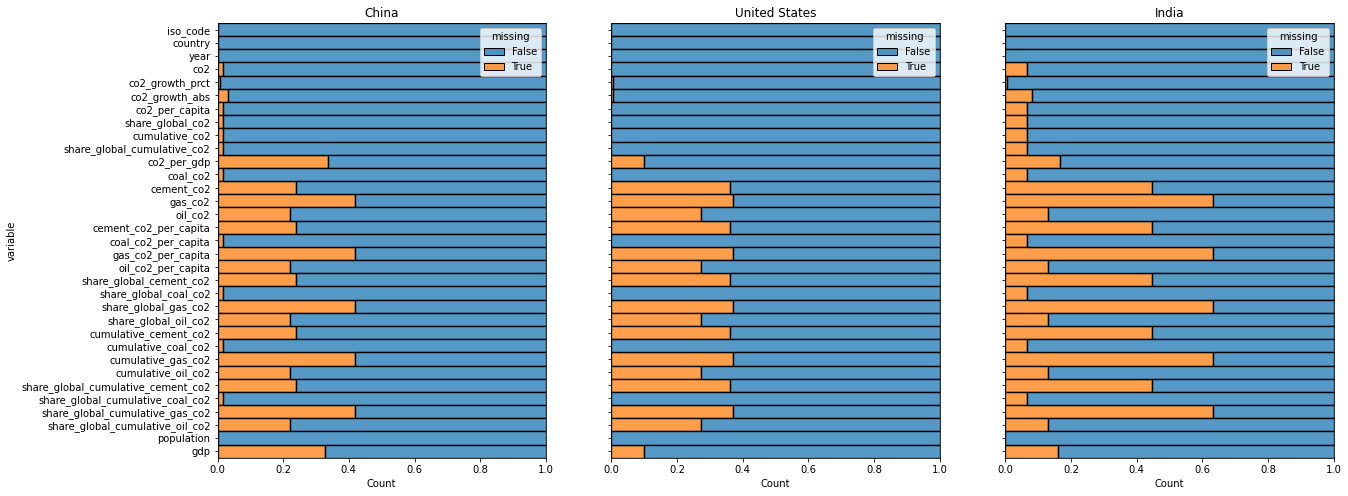

In [95]:
# check % of missing values
# not sorting because the order of columns might vary
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

missing_value = df_china2.isna().melt(value_name="missing")
sns.histplot(data=missing_value, y="variable", hue="missing", multiple="fill", ax=axes[0])
axes[0].set_title("China")

missing_value = df_us2.isna().melt(value_name="missing")
sns.histplot(data=missing_value, y="variable", hue="missing", multiple="fill", ax=axes[1])
axes[1].set_title("United States")

missing_value = df_india2.isna().melt(value_name="missing")
sns.histplot(data=missing_value, y="variable", hue="missing", multiple="fill", ax=axes[2])
axes[2].set_title("India")

plt.show()

### Multivariate Imputation

Next, we will be using multivariate imputation to fill up missing values


In [96]:
print(df_china2.shape)
print(df_us2.shape)
print(df_india2.shape)

(122, 33)
(221, 33)
(163, 33)


In [97]:
print(122*0.8)
print(221*0.8)
print(163*0.8)

97.60000000000001
176.8
130.4


In [98]:
def multivariate_imputation(df):

    df_train = df.iloc[:-25] 
    df_test = df[-25:] # last 25 years

    print(f'Training years: {df_train.shape[0]}')
    print(f'Test years: {df_test.shape[0]}')

    imp = IterativeImputer(max_iter=10, random_state=2022)
    imp.fit(df_train.iloc[:,3:]) 

    df_predict_array = imp.transform(df_test.iloc[:,3:])

    columns = df.columns.tolist()[3:]
    df_predict = pd.DataFrame(df_predict_array, columns=columns) # array to df

    df_predict['iso_code'] = df['iso_code']
    df_predict['country'] = df['country']
    df_predict['year'] = df_test['year'].to_list() # predicted years

    df_predict = df_predict.reindex(columns=df_test.columns.tolist())
    return df_predict
    

In [99]:
df_china_predict = multivariate_imputation(df_china2)
df_china_predict

Training years: 97
Test years: 25


,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,...,cumulative_cement_co2,cumulative_coal_co2,cumulative_gas_co2,cumulative_oil_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,population,gdp
0,CHN,China,1996,3503.234,4.33,145.325,2.799,14.50,61223.916,6.47,...,1834.135,48780.180,698.314,8219.917,11.76,9.96,0.68,2.52,1.251636e+09,5.127590e+12
1,CHN,China,1997,3510.169,0.20,6.936,2.781,14.44,64734.085,6.67,...,2037.009,51389.736,742.473,8777.878,12.53,10.30,0.69,2.62,1.261996e+09,5.291339e+12
2,CHN,China,1998,3360.455,-4.27,-149.714,2.642,13.88,68094.541,6.84,...,2248.377,53834.507,792.974,9337.140,13.30,10.61,0.71,2.70,1.271982e+09,5.338703e+12
3,CHN,China,1999,3350.340,-0.30,-10.115,2.614,13.66,71444.881,7.01,...,2476.699,56212.997,847.545,9933.891,14.08,10.89,0.73,2.80,1.281515e+09,5.578503e+12
4,CHN,China,2000,3439.152,2.65,88.812,2.665,13.63,74884.033,7.17,...,2721.087,58609.423,907.342,10582.576,14.86,11.16,0.75,2.89,1.290551e+09,5.952682e+12
5,CHN,China,2001,3514.934,2.20,75.782,2.706,13.81,78398.967,7.32,...,2991.916,61038.280,974.499,11241.877,15.70,11.43,0.77,2.99,1.299130e+09,6.329737e+12
6,CHN,China,2002,3872.595,10.18,357.662,2.962,14.87,82271.562,7.50,...,3288.506,63817.050,1028.492,11894.963,16.57,11.74,0.78,3.08,1.307352e+09,6.814494e+12
7,CHN,China,2003,4545.014,17.36,672.419,3.456,16.61,86816.576,7.72,...,3633.692,67136.330,1089.238,12622.062,17.56,12.12,0.80,3.18,1.315304e+09,7.248623e+12
8,CHN,China,2004,5223.755,14.93,678.741,3.948,18.25,92040.331,7.99,...,4013.684,70971.618,1160.759,13461.155,18.58,12.56,0.82,3.30,1.323085e+09,7.830953e+12
9,CHN,China,2005,5876.555,12.50,652.801,4.416,19.85,97916.886,8.28,...,4425.333,75396.008,1245.716,14311.327,19.61,13.08,0.85,3.41,1.330776e+09,8.602940e+12


In [100]:
df_us_predict = multivariate_imputation(df_us2)
df_us_predict

Training years: 196
Test years: 25


,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,...,cumulative_cement_co2,cumulative_coal_co2,cumulative_gas_co2,cumulative_oil_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,population,gdp
0,USA,United States,1996,5610.582,3.49,189.079,20.909,23.23,281080.074,29.69,...,1786.817,131366.959,44261.319,101841.399,11.46,26.83,42.95,31.27,268335007.0,1.090917e+13
1,USA,United States,1997,5686.465,1.35,75.883,20.928,23.40,286766.539,29.53,...,1825.378,133434.186,45484.654,104132.397,11.23,26.76,42.32,31.05,271713634.0,1.139876e+13
2,USA,United States,1998,5731.050,0.78,44.585,20.827,23.68,292497.589,29.39,...,1864.839,135529.162,46685.417,106463.243,11.03,26.71,41.70,30.84,275175309.0,1.190603e+13
3,USA,United States,1999,5804.669,1.28,73.619,20.839,23.67,298302.258,29.25,...,1905.077,137629.479,47890.132,108857.680,10.83,26.66,41.08,30.64,278548148.0,1.246382e+13
4,USA,United States,2000,6010.508,3.55,205.839,21.336,23.82,304312.766,29.12,...,1946.523,139809.318,49147.731,111326.820,10.63,26.62,40.51,30.45,281710914.0,1.297384e+13
5,USA,United States,2001,5904.882,-1.76,-105.627,20.747,23.20,310217.648,28.98,...,1988.136,141924.378,50352.471,113808.804,10.43,26.57,39.93,30.27,284607992.0,1.310047e+13
6,USA,United States,2002,5946.771,0.71,41.889,20.700,22.84,316164.418,28.83,...,2031.300,144043.700,51597.237,116285.375,10.23,26.49,39.38,30.10,287279312.0,1.333449e+13
7,USA,United States,2003,6011.837,1.09,65.067,20.744,21.97,322176.256,28.67,...,2074.649,146202.277,52808.352,118822.584,10.02,26.39,38.79,29.93,289815567.0,1.370881e+13
8,USA,United States,2004,6114.007,1.70,102.169,20.913,21.36,328290.263,28.48,...,2120.535,148392.608,54025.974,121418.869,9.82,26.27,38.21,29.76,292354663.0,1.422788e+13
9,USA,United States,2005,6134.521,0.34,20.515,20.795,20.72,334424.784,28.29,...,2166.729,150607.446,55225.270,124027.346,9.60,26.13,37.62,29.59,294993509.0,1.470373e+13


In [101]:
df_india_predict = multivariate_imputation(df_india2)
df_india_predict

Training years: 138
Test years: 25


,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,...,cumulative_cement_co2,cumulative_coal_co2,cumulative_gas_co2,cumulative_oil_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,population,gdp
0,IND,India,1996,825.919,8.37,63.798,0.841,3.42,15271.672,1.61,...,490.018,10697.416,312.762,3658.083,3.14,2.18,0.30,1.12,9.823652e+08,2.323733e+12
1,IND,India,1997,859.686,4.09,33.767,0.859,3.54,16131.358,1.66,...,527.436,11225.890,358.785,3902.285,3.24,2.25,0.33,1.16,1.000900e+09,2.403114e+12
2,IND,India,1998,877.698,2.10,18.012,0.861,3.63,17009.056,1.71,...,566.463,11750.762,406.381,4165.177,3.35,2.32,0.36,1.21,1.019484e+09,2.541494e+12
3,IND,India,1999,951.749,8.44,74.051,0.917,3.88,17960.805,1.76,...,611.055,12312.088,448.696,4465.687,3.47,2.39,0.38,1.26,1.038058e+09,2.681321e+12
4,IND,India,2000,978.919,2.85,27.171,0.926,3.88,18939.724,1.81,...,657.012,12885.780,492.569,4777.973,3.59,2.45,0.41,1.31,1.056576e+09,2.773211e+12
5,IND,India,2001,992.560,1.39,13.641,0.923,3.90,19932.284,1.86,...,703.752,13468.692,536.138,5094.089,3.69,2.52,0.43,1.35,1.075000e+09,2.906878e+12
6,IND,India,2002,1023.027,3.07,30.467,0.936,3.93,20955.311,1.91,...,752.863,14068.142,583.272,5418.676,3.79,2.59,0.45,1.40,1.093317e+09,2.989576e+12
7,IND,India,2003,1059.616,3.58,36.589,0.953,3.87,22014.927,1.96,...,803.743,14694.924,633.260,5748.613,3.88,2.65,0.47,1.45,1.111523e+09,3.212954e+12
8,IND,India,2004,1125.471,6.21,65.855,0.996,3.93,23140.399,2.01,...,859.288,15365.846,682.844,6096.131,3.98,2.72,0.48,1.49,1.129623e+09,3.454211e+12
9,IND,India,2005,1185.953,5.37,60.482,1.033,4.01,24326.352,2.06,...,918.974,16088.342,733.283,6447.777,4.07,2.79,0.50,1.54,1.147610e+09,3.709371e+12


Saving into above df into csv files

In [102]:
df_china_predict.to_csv('output/owid_df_china_predict.csv', index=False)
df_us_predict.to_csv('output/owid_df_us_predict.csv', index=False)
df_india_predict.to_csv('output/owid_df_india_predict.csv', index=False)
print('Completed!')

Completed!
